# Exploratory Analysis for Frame

In [4]:
%matplotlib inline
from StringIO import StringIO
from requests import get
import pandas
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np

class FrameClassifier():
    def __init__(self):
        self.features = ['latency', 'bandwidth', 'framerate']    
        #self.features = ['latency', 'bandwidth']    

    def get_data(self,csv=None):
        uri = 'http://ds/api/warehouse/all-the-frame-metrics-by-step?fmt=csv'
        resp = get(uri)
        self.respondents = pandas.read_csv(StringIO(resp.text))        
        self.respondents = self.respondents[self.respondents.name == 'Unity Frame Shopping']
        X, y = self.respondents[self.features], self.respondents.iscomplete
        #self.respondents['latency'] =self.respondents['latency'].apply(lambda x: math.log(x+.000000000000000000000001))
        #self.respondents['bandwidth'] = self.respondents['bandwidth'].apply(lambda x: math.log(x+.000000000000000000000001))
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y,test_size=0.05,random_state=0)

        sc = StandardScaler()
        sc.fit(self.X_train)
        self.X_train_std = sc.transform(self.X_train)
        self.X_test_std = sc.transform(self.X_test)
        
    def do_PCA(self):
        pca = PCA(n_components=None)
        self.X_train_pca = pca.fit_transform(self.X_train_std)
        self.X_test_pca = pca.transform(self.X_test_std)

        self.weights = dict(zip(self.features,pca.explained_variance_ratio_))
        print "Principle Components:"
        for pc in self.weights:
            print pc, self.weights[pc]    


    def basic(self):
        self.do_PCA()
        lr = LogisticRegression(C=1)
        lr = lr.fit(self.X_train_pca, self.y_train)
        self.y_pred = lr.predict(self.X_test_pca)
        print('Misclassified samples: %d' % (self.y_test != self.y_pred).sum())
        print('Accuracy: %.2f' % accuracy_score(self.y_test, self.y_pred))
        print classification_report(self.y_test, self.y_pred)        
        print confusion_matrix(self.y_test, self.y_pred)
        print lr.get_params

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not Complete', 'Complete'], rotation=45)
    plt.yticks(tick_marks, ['Not Complete', 'Complete'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Principle Components:
latency 0.629866936694
bandwidth 0.240117247083
framerate 0.130015816223
Misclassified samples: 21
Accuracy: 0.92
             precision    recall  f1-score   support

      False       0.00      0.00      0.00        21
       True       0.92      1.00      0.96       244

avg / total       0.85      0.92      0.88       265

[[  0  21]
 [  0 244]]
<bound method LogisticRegression.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>


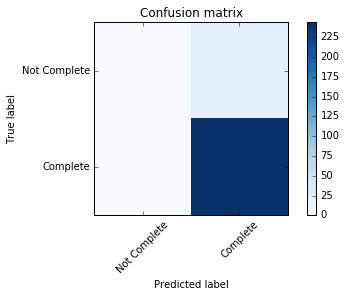

Test Accuracy: 0.921


In [5]:
fc = FrameClassifier()
fc.get_data()

a = fc.respondents
fc.basic()
cm = confusion_matrix(fc.y_test, fc.y_pred)
plot_confusion_matrix(cm)
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=len(fc.features))),
            ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(fc.X_train_std, fc.y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(fc.X_test_std, fc.y_test))